### Chargement et analyse du dataset

In [124]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LassoLarsIC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from scipy.optimize import minimize
import glob2 as glob2
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import pairwise_distances
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix, hstack, vstack, lil_matrix
import itertools
from sklearn.cluster import spectral_clustering, KMeans, MiniBatchKMeans
from sklearn.neighbors import kneighbors_graph
from nltk.corpus import wordnet as wn
from sklearn import metrics
import json
import requests
from IPython.display import Image
from IPython.core.display import HTML
import scipy.sparse as sp
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.decomposition import TruncatedSVD
import re

In [2]:
# List Files
ListFiles = glob2.glob('ml-latest/*.csv')
ListFiles

['ml-latest/tags.csv',
 'ml-latest/genome-scores.csv',
 'ml-latest/ratings.csv',
 'ml-latest/links.csv',
 'ml-latest/genome-tags.csv',
 'ml-latest/movies.csv']

In [3]:
# load data as Dataframes
#tags_df = pd.read_csv(ListFiles[0])
#gen_sc_df = pd.read_csv(ListFiles[1])
rat_df = pd.read_csv(ListFiles[2])
links_df = pd.read_csv(ListFiles[3])
#gen_tags_df = pd.read_csv(ListFiles[4])
movies_df = pd.read_csv(ListFiles[5])

In [4]:
# tags describing each movies according to userid
# tags_df.head()

In [5]:
# Relevance of each tags
# gen_sc_df.head()

In [6]:
# ratings of each movies by user id
rat_df.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [7]:
# imdb references of movies in the dataset
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [8]:
# tagsid to tags
# gen_tags_df.head()

In [9]:
# gen_tags_df.tag.unique().shape[0]
# we have 1128 different tags for 45943 movies -> clustering

In [10]:
# Movies information
genres = ['Action', 'Adventure', 'Animation', "Children's",
          "Comedy", "Crime", "Documentary", "Drama", "Fantasy",
          "Film - Noir", "Horror", "Musical", "Mystery", "Romance"
          "Sci - Fi", "Thriller", "War", "Western"]
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [11]:
n_movies = movies_df.movieId.unique()
n_users = rat_df.userId.unique()
print('We have %d movies and %d users ' %
      (n_movies.shape[0], n_users.shape[0]))

We have 45843 movies and 270896 users 


### Our strategy will be :

 - recommend a film that has a high chance to be liked by the user in the mean time this film shoul be a discovery.
 - In fact we think people who likes our small cinema, likes being surprised and get deeper in movie culture than usual people using Netflix for example.

 
### What we will try to develop:
 
 - We will combine several kind of recommendation system : Model Based CollaborativeFilters and differents clusters (genres, tags, users).
 - Our goal will be to recommend movies at the edge of people tastes / discoveries.
 - We have ruled out content based algorithms for now because, the imdb API access is limited to 1000 films daily hence it will take a month to built a content database.
 - We will in the first time ignore the timestamp parameter, we might give a weight in the future of each ratings depending on the date the ratings was done.
 
### What we have done :

 - 1) Built a Kmeans Cluster model with movies genres (125 centers), we will take the films belongs n closest clusters. 
 - 2) From the list of film belong to the n cluster we builf a model based CF with SVD. 
 - 3) From the tags score dense matrix we built Kmeans cluster model 100 centers
 - 4) We combine the score from 2 and 3 to get a top 10 films with imdb ratings
 - 5) We give 10 films recommendation to the user
 
### See the end of Notebook for improvement.
         
 
 

In [12]:
# First as the dimension is too large for my RAM available
# let's reduce dimension through genre movies clustering
# in fact 270896,45843 is too big for a 6 hours exercice

# first let's get all the tokens


def MakeVector(raw):
    raw[raw['listgenres']] = 1
    return raw


genreslist = movies_df['genres'].str.split('|')
genreslist = [l for x in genreslist for l in x]
genreslist = set(genreslist)
data = np.zeros((movies_df.shape[0], len(genreslist)))
movies_genre_df = pd.DataFrame(columns=genreslist, data=data)
movies_genre_df['movieId'] = movies_df['movieId']
movies_genre_df['listgenres'] = movies_df['genres'].str.split('|')
movies_genre_df = movies_genre_df.apply(MakeVector, axis=1)

In [13]:
movies_genre_df.to_csv('movie_genre.csv')
movies_genre_df.drop(['(no genres listed)', 'listgenres'],
                     axis=1, inplace=True)

In [14]:
movies_genre_df.set_index('movieId')
print(movies_genre_df.shape)

(45843, 20)


In [15]:
movies_genre_df.head()

,Documentary,Fantasy,Sci-Fi,Thriller,Mystery,War,Drama,Horror,Adventure,Western,Children,IMAX,Comedy,Animation,Crime,Action,Film-Noir,Musical,Romance,movieId
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5


In [16]:
X = movies_genre_df.drop(['movieId'], axis=1)
X.columns

Index(['Documentary', 'Fantasy', 'Sci-Fi', 'Thriller', 'Mystery', 'War',
       'Drama', 'Horror', 'Adventure', 'Western', 'Children', 'IMAX', 'Comedy',
       'Animation', 'Crime', 'Action', 'Film-Noir', 'Musical', 'Romance'],
      dtype='object')

In [17]:
# Let's apply some clustering now
# As we want to reduce dimension before applying collaborative filtering
n_clusters = range(20, 225, 5)
inertia = []
calinski_metric = []
for c in n_clusters:
    kmeans = KMeans(n_clusters=c, random_state=26, n_jobs=-1)
    kmeans.fit(X.values)
    labels = kmeans.labels_
    inertia.append(kmeans.inertia_)
    calinski_metric.append(metrics.calinski_harabaz_score(X.values, labels))

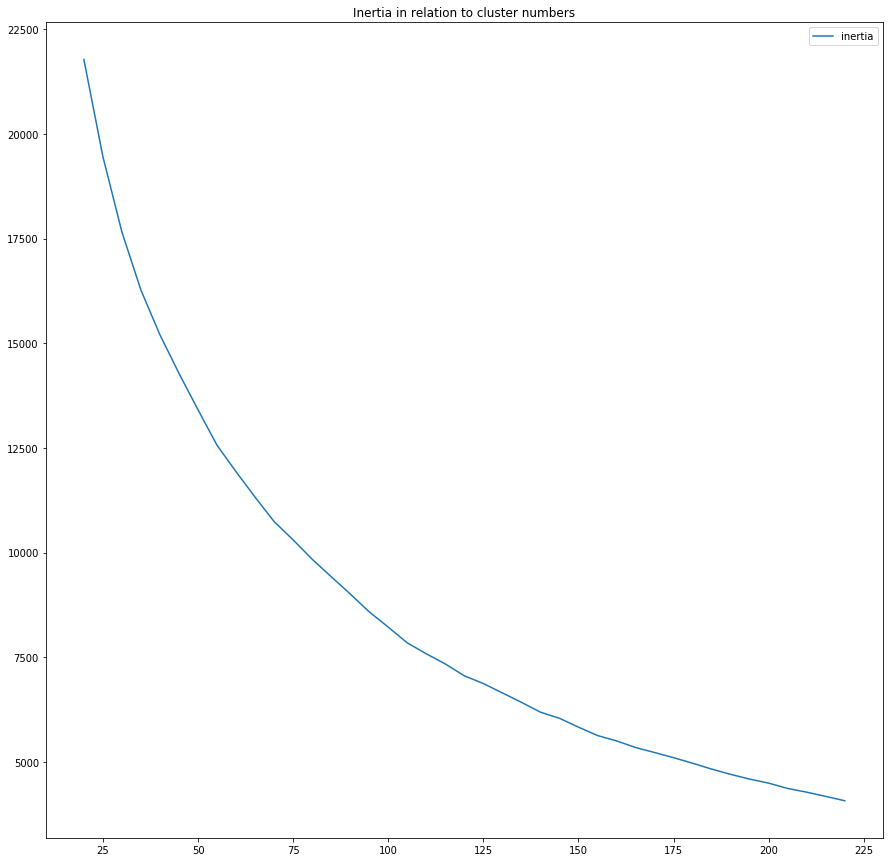

In [18]:
# let s plot the result in order to get the optimal numbers of clusters
plt.figure(figsize=(15, 15))
plt.plot(n_clusters, inertia, label='inertia')
plt.title('Inertia in relation to cluster numbers')
plt.legend()
plt.show()

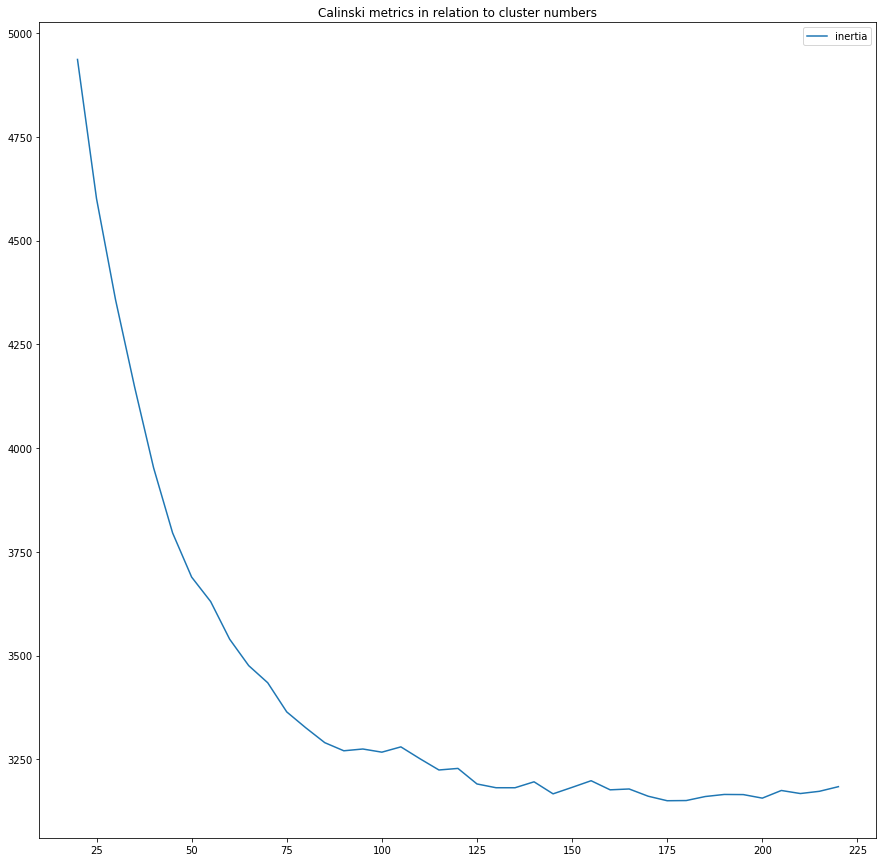

In [19]:
plt.figure(figsize=(15, 15))
plt.plot(n_clusters, calinski_metric, label='inertia')
plt.title('Calinski metrics in relation to cluster numbers')
plt.legend()
plt.show()

In [20]:
# let's choose 125 Clusters
# let's have a look at the meaning of the centroids
kmeans = KMeans(n_clusters=125, random_state=26, n_jobs=-1)
kmeans.fit(X.values)
cent = kmeans.cluster_centers_

In [21]:
print('principal components of 26 are',
      cent[25, np.argsort(cent[25, :])[-3:]])
print(X.columns[np.argsort(cent)[25, -3:]])

principal components of 26 are [0.69672131 1.         1.        ]
Index(['Thriller', 'Horror', 'Crime'], dtype='object')



## Let's look at Inferno Now

In [22]:
inferno_movie_details = movies_df[movies_df.title.str.contains('Inferno')]
inferno_movie_details

,movieId,title,genres
2440,2524,"Towering Inferno, The (1974)",Action|Adventure|Drama|Thriller
3497,3587,Inferno (1980),Horror
9589,30791,Hellraiser: Inferno (2000),Horror
9753,31655,Inferno (1953),Drama
11384,48536,Dante's Inferno (1935),Action|Drama
11546,49979,Desert Heat (Inferno) (1999),Action
14849,74115,Dante's Inferno Animated (2010),Action|Animation|Fantasy
17316,87164,Henri-Georges Clouzot's Inferno (L'enfer d'Hen...,Documentary
19010,94160,Dante's Inferno: An Animated Epic (2010),Action|Animation|Fantasy
20501,100093,Death Race 3: Inferno (2012),Action|Sci-Fi|Thriller


In [23]:
imdbref = int(links_df[links_df.movieId == 165101]['imdbId'].values)
imdbref

3062096

In [99]:
# film has been released in 2016
# let's check if it is the 165101
# we have registered to imdb let s get the details

api_key = '89b358a2'
url = "http://www.omdbapi.com/?i=tt" + str(imdbref) + "&apikey=" + api_key
response = requests.get(url)
film_details = json.loads(response.text)
print(film_details['Director'])
Image(url=film_details['Poster'])

Ron Howard


In [25]:
# that s the good one.
# check to which cluster he belongs to
# First let s find it in movies_genre
X_inferno = movies_genre_df[movies_genre_df.movieId == 165101]
X_inferno

,Documentary,Fantasy,Sci-Fi,Thriller,Mystery,War,Drama,Horror,Adventure,Western,Children,IMAX,Comedy,Animation,Crime,Action,Film-Noir,Musical,Romance,movieId
41308,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,165101


In [26]:
label = int(kmeans.predict(
    X_inferno.values[:, :X_inferno.values.shape[1] - 1]))
print('Inferno by Ron Howard belongs to center number', label)
score = kmeans.score(X_inferno.values[:, :X_inferno.values.shape[1] - 1])
print('Inferno by Ron Howard has a score of ', score)

Inferno by Ron Howard belongs to center number 46
Inferno by Ron Howard has a score of  -0.02628245088379


In [27]:
print('principal components of 46 center are',
      cent[46, np.argsort(cent[46, :])[-5:]])
print(X.columns[np.argsort(cent)[46, -5:]])

principal components of 46 center are [0.06278027 0.08071749 0.10313901 1.         1.        ]
Index(['Comedy', 'Romance', 'Sci-Fi', 'Mystery', 'Thriller'], dtype='object')


### Inferno is quite close to the cluster center as the score is very low, we check it with the main feature of Inferno as  'Sci-Fi', 'Mystery', 'Thriller' given by our model

In [28]:
# let's get all the films belongs to this center
y_kmeans = kmeans.predict(X.values)

In [29]:
print('We have ' +
      str(len(y_kmeans[y_kmeans == 46])) + ' films in this cluster')

We have 223 films in this cluster


In [30]:
# let's take the film belongs to the four closest clusters
# this will b refined through Cross Val later
# I have limited to 1000 films because of computing power
dist_cent = pairwise_distances(cent, metric='euclidean', n_jobs=-1)

In [40]:
print('closest clusters are',
      str(np.argsort(dist_cent[46, :])[:4]))
clusterlist = list(np.argsort(dist_cent[46, :])[:4])
clusterlist.append(46)
clusterlist = np.asanyarray(clusterlist)

closest clusters are [46 33  0 48]


In [42]:
# let's take the total list of films
# to apply Collaborative Filtering
list_film = np.argwhere(y_kmeans == clusterlist[0])
list_film = np.concatenate([list_film, np.argwhere(
    y_kmeans == clusterlist[1]), np.argwhere(y_kmeans == clusterlist[2]),
    np.argwhere(y_kmeans == clusterlist[3])], axis=0)
list_film.shape

(1375, 1)

In [43]:
print('We have ' +
      str(list_film.shape[0]) + ' films in this set of 4 clusters')

We have 1375 films in this set of 4 clusters


## Collaborative Filtering

In [44]:
# User Item Matrix
# Get all the movieId corresponding to our list of films

MovieId_list = movies_genre_df.loc[list_film.ravel(), 'movieId'].values
MovieId_list

array([    32,     47,    103, ..., 176077, 176207, 176255])

In [45]:
# let's built the item user matrix
UserItem = rat_df[rat_df.movieId.isin(MovieId_list)].pivot_table(
    index='userId', columns='movieId', values='rating', fill_value=0)

In [46]:
# put 0 in order to find solution
print('number of users:', UserItem.shape[0])
print('number of film', UserItem.shape[1])

number of users: 170380
number of film 1363


### We implement a model based CF as Netflix, svd


In [47]:
# let's split our dataset into Train, Test
# As we do not make any GridSearch
# we will not need a validation set to validate our k
X_train = UserItem.values[:int(UserItem.shape[0] * 0.9), :]
X_test = UserItem.values[int(UserItem.shape[0] * 0.9):, :]

In [48]:
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [49]:
# get SVD components from train matrix.
# I cannot make a grid search for the best k -> not enough RAM
u, s, vt = svds(X_train, k=26)
s_diag_matrix = np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
score = rmse(X_pred, X_test)

In [50]:
print('CF MSE: ' + str(score))

CF MSE: 3.5402796181208016


In [51]:
X_pred.shape

(153342, 1363)

In [52]:
X_pred_df = pd.DataFrame(data=X_pred, columns=UserItem.columns)

In [53]:
X_pred_df.head()

movieId,32,47,103,132,190,200,226,240,257,320,...,175331,175419,175553,175601,175701,175755,175991,176077,176207,176255
0,-0.007241,0.007776,-0.017677,-0.021750,0.001140,-0.002011,-0.000080,-0.005552,-0.028944,-0.000616,...,-0.000411,-0.000122,-1.859317e-07,-0.000208,-0.000246,-1.225185e-18,1.895266e-04,-0.000265,-2.005416e-05,0.000114
1,1.994161,0.000059,0.017010,0.006632,0.000365,0.000412,0.000267,0.003659,0.008762,0.001651,...,0.000012,-0.000005,4.173010e-06,-0.000027,0.000061,-1.214556e-18,-1.920382e-05,0.000018,-6.419082e-08,0.000019
2,-0.038739,0.041965,-0.035559,-0.018094,-0.042583,-0.005145,-0.002192,-0.010205,-0.045353,-0.008650,...,-0.000486,0.000427,8.522974e-06,-0.000211,-0.000231,9.334714e-19,-1.030604e-04,0.000299,6.054747e-05,-0.000016
3,0.021124,0.013725,0.029879,0.048352,0.014374,0.010594,0.001083,0.025608,0.105241,0.010673,...,0.000056,-0.000139,4.536294e-06,0.000212,0.000003,2.260276e-18,1.083457e-07,-0.000175,-1.538118e-05,-0.000024
4,-0.071866,3.963359,0.052030,0.167891,0.096579,0.029730,0.005250,0.071617,0.225624,0.037572,...,0.000761,-0.000260,5.127847e-06,0.000564,0.000011,-2.562811e-18,9.995192e-05,-0.000094,3.796683e-05,0.000034


### We have some negative ratings -> we should apply a NMF (Non negative Matrix Factorisation)  next time.

In [54]:
X_pred_df.to_csv('CfModBasedPre.csv')

In [55]:
# Top 25 recommendation is the best average ratings
Top25 = X_pred_df.columns[np.argsort(np.mean(X_pred_df.values, axis=0))[-25:]]
Top25

Int64Index([ 8950,  1343,  4975,  1061, 68237,  2076,  5679,  1597, 27773,
             1645,  3176,   350,  2712, 70286, 74458,  1407,   903,  1625,
            48780,   904,  4878,  4226,    32,    47,   457],
           dtype='int64', name='movieId')

In [56]:
Top25details = movies_df[movies_df.movieId.isin(Top25)]
Top25details
#

,movieId,title,genres
31,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
46,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
346,350,"Client, The (1994)",Drama|Mystery|Thriller
453,457,"Fugitive, The (1993)",Thriller
886,903,Vertigo (1958),Drama|Mystery|Romance|Thriller
887,904,Rear Window (1954),Mystery|Thriller
1041,1061,Sleepers (1996),Thriller
1313,1343,Cape Fear (1991),Thriller
1374,1407,Scream (1996),Comedy|Horror|Mystery|Thriller
1545,1597,Conspiracy Theory (1997),Drama|Mystery|Romance|Thriller


In [57]:
Top25details.to_csv('Top25CFModelBased')

### Not bad at all :) Very good films like District 9, Memento, The Game

## Let's do a tag content based clustering and combine the scores

In [58]:
gen_sc_df = pd.read_csv(ListFiles[1])
gen_tags_df = pd.read_csv(ListFiles[4])

In [59]:
# Built a word2vec model to compute tag-meaning distances
# would be hard in the time given ( 6 hours)
# Let's take just the gen_sc to compute clustering as we already
# get the score of each tag for each movie
gen_sc_df.head()

,movieId,tagId,relevance
0,1,1,0.02475
1,1,2,0.02475
2,1,3,0.04900
3,1,4,0.07750
4,1,5,0.12450


In [60]:
# It s dense
print('different tags', gen_sc_df.tagId.unique().shape[0])
print('different movies', gen_sc_df.movieId.unique().shape[0])
print(np.isclose(gen_sc_df.tagId.unique(
).shape[0] * gen_sc_df.movieId.unique().shape[0], gen_sc_df.shape[0]))

different tags 1128
different movies 10993
True


In [62]:
# tag relevance dataframe building
tag_rel = gen_sc_df.pivot(index='movieId', columns='tagId', values='relevance')

In [63]:
tag_rel.head()

tagId,1,2,3,4,5,6,7,8,9,10,...,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.02475,0.02475,0.04900,0.07750,0.12450,0.23875,0.06575,0.28575,0.25400,0.02625,...,0.03125,0.02050,0.04300,0.03375,0.12375,0.04150,0.02125,0.03600,0.10425,0.02750
2,0.03750,0.04100,0.03675,0.04750,0.10000,0.05950,0.05125,0.09600,0.08875,0.01875,...,0.03425,0.01825,0.01650,0.02325,0.13525,0.02450,0.01825,0.01325,0.08550,0.01925
3,0.03800,0.04825,0.02650,0.07300,0.05475,0.06025,0.05750,0.15675,0.03900,0.02900,...,0.03700,0.02450,0.02650,0.03125,0.15700,0.03650,0.01750,0.01725,0.10525,0.02075
4,0.03125,0.03400,0.03375,0.02875,0.06175,0.03125,0.02250,0.07250,0.04400,0.02775,...,0.04650,0.03200,0.02150,0.03850,0.19150,0.06050,0.01725,0.01325,0.05650,0.01150
5,0.04100,0.05125,0.05550,0.03300,0.07475,0.11100,0.02900,0.07150,0.02075,0.02875,...,0.03575,0.02900,0.01875,0.02125,0.14300,0.02375,0.01500,0.01325,0.12125,0.02125


In [64]:
tag_rel.to_csv('tag_relevance.csv')
tag_rel.shape

(10993, 1128)

In [65]:
# we have to increase the cluster number to reach stability

n_clusters = range(100, 1100, 100)
inertia = []
calinski_metric = []
for c in n_clusters:
    kmeans = KMeans(n_clusters=c, random_state=26, n_jobs=-1)
    kmeans.fit(tag_rel.values)
    labels = kmeans.labels_
    inertia.append(kmeans.inertia_)
    calinski_metric.append(metrics.calinski_harabaz_score(tag_rel, labels))

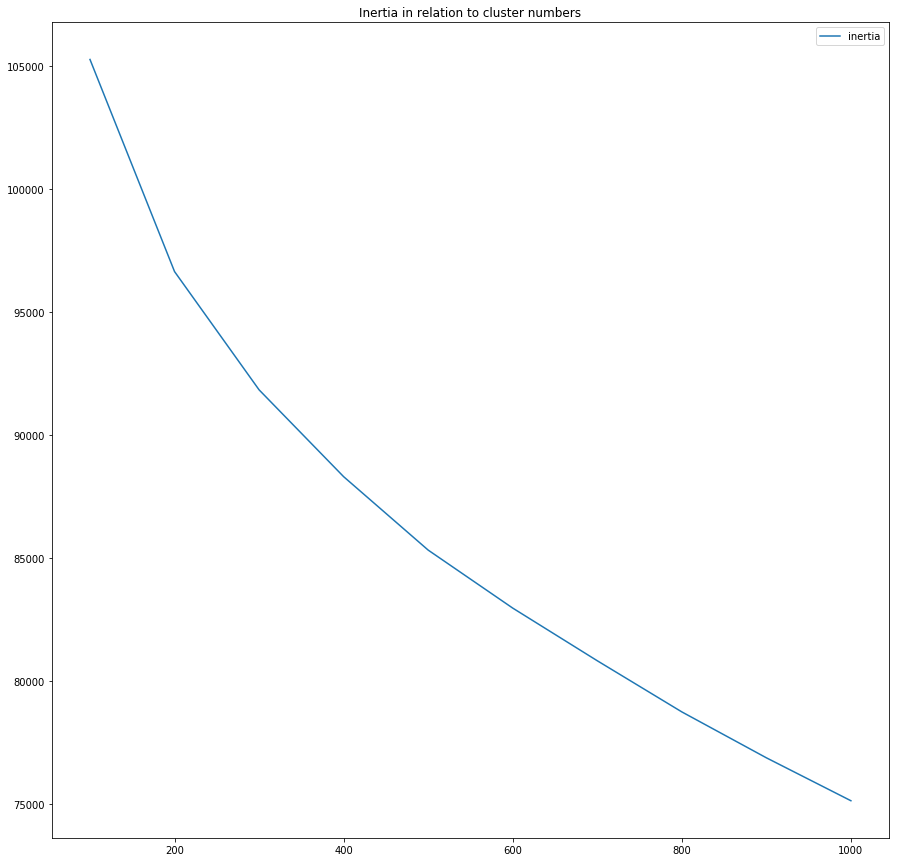

In [66]:
# let s plot the result in order to get the optimal numbers of clusters
plt.figure(figsize=(15, 15))
plt.plot(n_clusters, inertia, label='inertia')
plt.title('Inertia in relation to cluster numbers')
plt.legend()
plt.show()

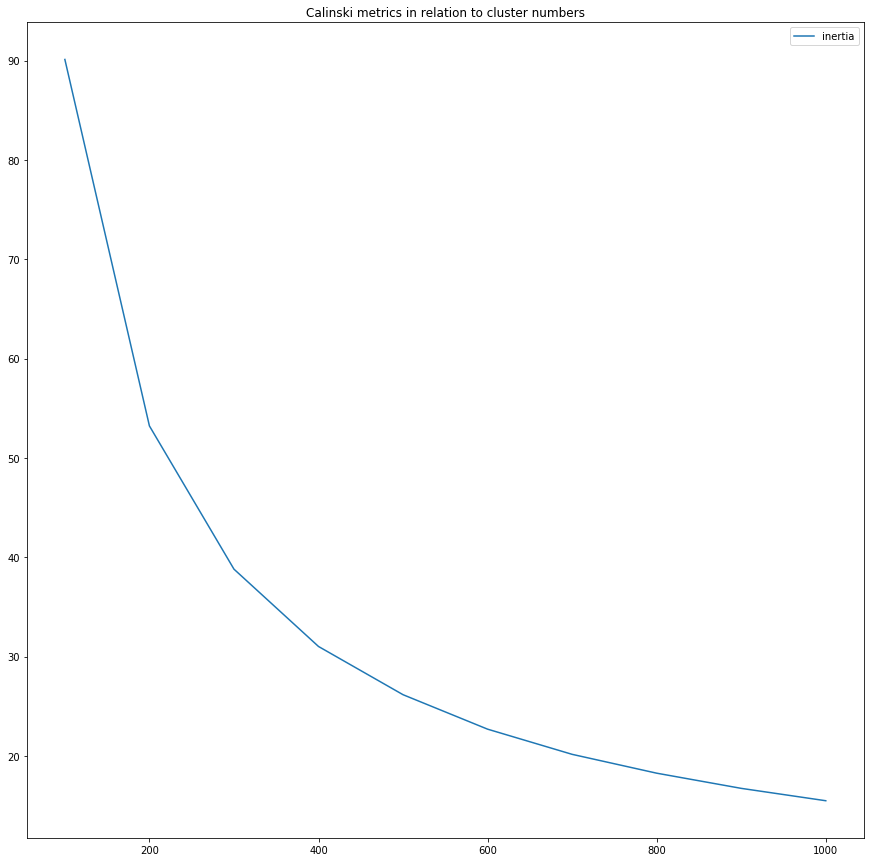

In [67]:
plt.figure(figsize=(15, 15))
plt.plot(n_clusters, calinski_metric, label='inertia')
plt.title('Calinski metrics in relation to cluster numbers')
plt.legend()
plt.show()

In [68]:
# Let' s try to just have the top 10 by this method
# hence make 1000 clusters
kmeans = KMeans(n_clusters=1000, random_state=26, n_jobs=-1)
kmeans.fit(tag_rel.values)
print("inertia is  :", kmeans.inertia_)
labels = kmeans.labels_
print('calinski harabaz score for dispersion withnin a cluster ',
      metrics.calinski_harabaz_score(tag_rel, labels))

inertia is  : 75123.8196237755
calinski harabaz score for dispersion withnin a cluster  15.492856958363507


In [88]:
# let's get the film belonging to the same cluster as Inferno
InfernoMovieId = 165101
X_tag_inferno = gen_sc_df[gen_sc_df.movieId == InfernoMovieId]
label = kmeans.predict(X_tag_inferno['relevance'].values.reshape(1, -1))
print('Inferno belongs to cluster number:', int(label))
print('Inferno score is:', kmeans.score(
    X_tag_inferno['relevance'].values.reshape(1, -1)))

Inferno belongs to cluster number: 884
Inferno score is: -6.743719621527781


### Inferno is quite far from cluster center

In [82]:
# let'analyse the centroids
centroids = kmeans.cluster_centers_
cent = pd.DataFrame(data=centroids, columns=gen_tags_df['tag'].values)
cent.head()

,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,19th century,...,world politics,world war i,world war ii,writer's life,writers,writing,wuxia,wwii,zombie,zombies
0,0.030500,0.033000,0.976750,0.10475,0.224250,0.079250,0.066750,0.084000,0.042250,0.17125,...,0.019000,0.023250,0.012500,0.030250,0.190500,0.051250,0.053000,0.009000,0.114750,0.018750
1,0.028995,0.031560,0.026875,0.03690,0.065955,0.055745,0.037345,0.083225,0.078495,0.02801,...,0.024710,0.016760,0.014345,0.030470,0.234465,0.033060,0.025230,0.008145,0.302470,0.091720
2,0.048083,0.059452,0.028571,0.03931,0.071595,0.036940,0.025810,0.119786,0.247476,0.02775,...,0.033905,0.017571,0.016405,0.030000,0.190167,0.043048,0.028345,0.010095,0.104167,0.019810
3,0.025875,0.031000,0.045000,0.09075,0.097000,0.093250,0.045375,0.138750,0.042250,0.02500,...,0.035375,0.026500,0.036750,0.120125,0.276625,0.093750,0.051250,0.019625,0.073000,0.024625
4,0.028500,0.033750,0.265250,0.09925,0.218750,0.348750,0.107250,0.069750,0.085750,0.02125,...,0.089000,0.020250,0.030750,0.217750,0.444750,0.118500,0.043500,0.021750,0.045750,0.011250


In [87]:
# let's check the inferno centroid if it makes sense
cent.columns[np.argsort(cent.values[884, :])[-15:]]

Index(['so bad it's funny', 'story', 'dialogue', 'predictable', 'great ending',
       'mentor', 'catastrophe', 'book was better', 'book', 'books',
       'adaptation', 'original', 'based on book', 'adapted from:book',
       'based on a book'],
      dtype='object')

### Seems not a very good one ;) which is true

In [89]:
# let 's take the film belonging to cluster 884
y_kmeans = kmeans.predict(tag_rel.values)

In [90]:
list_films_tag_cluster = np.argwhere(y_kmeans == 884)
list_films_tag_cluster

array([[  178],
       [  225],
       [  258],
       [  899],
       [ 1856],
       [ 1882],
       [ 2026],
       [ 2325],
       [ 2909],
       [ 2999],
       [ 3631],
       [ 4386],
       [ 5537],
       [ 5653],
       [ 7064],
       [ 8138],
       [ 8555],
       [ 9325],
       [ 9406],
       [ 9690],
       [10313],
       [10685],
       [10735],
       [10908]])

In [91]:
movied_in_tag = gen_sc_df.movieId.unique()
movied_in_tag

array([     1,      2,      3, ..., 174053, 174055, 174585])

In [94]:
# movieId list
tag_movieId = movied_in_tag[list_films_tag_cluster.ravel()]

In [95]:
tag_cluster_details = movies_df[movies_df.movieId.isin(tag_movieId)]
tag_cluster_details

,movieId,title,genres
189,191,"Scarlet Letter, The (1995)",Drama|Romance
237,240,Hideaway (1995),Thriller
270,273,Mary Shelley's Frankenstein (Frankenstein) (1994),Drama|Horror|Sci-Fi
987,1006,"Chamber, The (1996)",Drama
2037,2120,Needful Things (1993),Drama|Horror
2064,2147,"Clan of the Cave Bear, The (1986)",Adventure|Drama|Fantasy
2230,2314,Beloved (1998),Drama
2555,2639,Mommie Dearest (1981),Drama
3199,3285,"Beach, The (2000)",Adventure|Drama
3316,3403,Raise the Titanic (1980),Drama|Thriller


### Now let'combine the result by taking the 10 best rated in imdB from both methods

In [113]:
Imdbmeanrating = np.zeros(len(movieIdFinal))
movieIdFinal = list(Top25details.movieId.values)
movieIdFinal.extend(list(tag_cluster_details.movieId.values))
imdbref_final = links_df[links_df.movieId.isin(movieIdFinal)]['imdbId'].values

In [125]:

regexp = r"(\d+)"

for i, r in enumerate(imdbref_final):
    sc = np.empty(3, dtype=float)
    url = "http://www.omdbapi.com/?i=tt" + str(r) + "&apikey=" + api_key
    response = requests.get(url)
    film_details = json.loads(response.text)
    if 'Error' in film_details.keys():
        url = "http://www.omdbapi.com/?i=tt0" + str(r) + "&apikey=" + api_key
        response = requests.get(url)
        film_details = json.loads(response.text)

    if 'Ratings' in film_details.keys():
        print(film_details["Ratings"])
        print(len(film_details["Ratings"]))
        if len(film_details['Ratings']) > 0:
            sc[0] = float(
                re.search(regexp, film_details['Ratings'][0]['Value']).group(0)) / 10
        if len(film_details['Ratings']) > 1:
            sc[1] = float(
                re.search(regexp, film_details['Ratings'][1]['Value']).group(0)) / 100
        if len(film_details['Ratings']) > 2:
            sc[2] = float(
                re.search(regexp, film_details['Ratings'][2]['Value']).group(0)) / 100
        Imdbmeanrating[i] = np.mean(sc)
    print(i)

[{'Source': 'Internet Movie Database', 'Value': '8.0/10'}, {'Source': 'Rotten Tomatoes', 'Value': '88%'}, {'Source': 'Metacritic', 'Value': '74/100'}]
3
0
[{'Source': 'Internet Movie Database', 'Value': '8.6/10'}, {'Source': 'Rotten Tomatoes', 'Value': '80%'}, {'Source': 'Metacritic', 'Value': '65/100'}]
3
1
[{'Source': 'Internet Movie Database', 'Value': '5.2/10'}, {'Source': 'Rotten Tomatoes', 'Value': '14%'}]
2
2
[{'Source': 'Internet Movie Database', 'Value': '5.3/10'}, {'Source': 'Rotten Tomatoes', 'Value': '14%'}]
2
3
[{'Source': 'Internet Movie Database', 'Value': '6.4/10'}, {'Source': 'Rotten Tomatoes', 'Value': '39%'}]
2
4
[{'Source': 'Internet Movie Database', 'Value': '6.7/10'}, {'Source': 'Rotten Tomatoes', 'Value': '78%'}, {'Source': 'Metacritic', 'Value': '65/100'}]
3
5
[{'Source': 'Internet Movie Database', 'Value': '7.8/10'}, {'Source': 'Rotten Tomatoes', 'Value': '96%'}, {'Source': 'Metacritic', 'Value': '88/100'}]
3
6
7
8
[{'Source': 'Internet Movie Database', 'Value'

In [126]:
Imdbmeanrating

array([0.80666667, 0.75      , 0.46      , 0.43      , 0.57666667,
       0.67666667, 0.84666667, 0.        , 0.        , 0.39      ,
       0.64333333, 0.72666667, 0.71333333, 0.54      , 0.67666667,
       0.65333333, 0.        , 0.43      , 0.        , 0.61666667,
       0.        , 0.70666667, 0.76333333, 0.40666667, 0.        ,
       0.        , 0.84      , 0.84666667, 0.        , 0.49      ,
       0.66      , 0.        , 0.        , 0.69333333, 0.66      ,
       0.78      , 0.73666667, 0.71333333, 0.49666667, 0.75333333,
       0.83666667, 0.70333333, 0.29333333, 0.61333333, 0.26666667,
       0.34      , 0.36333333, 0.46      , 0.41333333])

In [127]:
# Let's take the Top 10 best
Top10_Final = np.argsort(Imdbmeanrating)[-10:]
Top10_Final

array([36,  1, 39, 22, 35,  0, 40, 26,  6, 27])

In [129]:
i = 0
title = []
for i, r in enumerate(imdbref_final[Top10_Final]):
    sc = np.empty(3, dtype=float)
    url = "http://www.omdbapi.com/?i=tt" + str(r) + "&apikey=" + api_key
    response = requests.get(url)
    film_details = json.loads(response.text)
    if 'Error' in film_details.keys():
        url = "http://www.omdbapi.com/?i=tt0" + str(r) + "&apikey=" + api_key
        response = requests.get(url)
        film_details = json.loads(response.text)
    title.append(film_details['Title'])
    display(Image(url=film_details['Poster']))

In [130]:
title

['The Prestige',
 'Se7en',
 'Moon',
 'The Talented Mr. Ripley',
 'Oldboy',
 'Twelve Monkeys',
 'District 9',
 'Memento',
 'The Fugitive',
 'Donnie Darko']

## We would recommend the title in the reverse order of title array, we have selected good films. It seems that our POC is working but need many improvements :)

- We need to refine the genre cluster model  -> cluster number
- We need to improve the n closest cluster we take for each genre cluster
- We need to find other matrix factorisation model like ( NMF, regularized SVD ) to avoid negative ratings
- We need to refine with sentiment analysis the tag content cluster model
- We need to add some content based model
- We need more computational power and move to Deep learning for scalabiity
- We need also to keep tracks of our user to refine our model
- We need better evaluation metric!!!!! 

# I like a lot this challenge took me about 8 hours to complete ( computational time included). It's never ending problem :) 
# We have combine: 
- Clustering of movies genre
- Collaborative Filtering Based Model
- Clustering of tags 
- Popularity with imdb rating

